In [6]:
import numpy as np
import pandas as pd
import catboost as cb
import warnings

from nbclient.client import timestamp

warnings.filterwarnings("ignore")

In [2]:
bd = pd.read_csv('credit-c61fbdb3-e0af-4b7b-9301-6ba7a994eeca.csv')

In [4]:
names = {'колонка_0' : 'approve_dttm', 'колонка_1' : 'utm_source', 'колонка_2' : 'specialty', 'колонка_3' : 'util_dttm', 'колонка_4' : 'semestr_cost_amt', 'колонка_5' : 'pid', 'колонка_6' : 'score', 'колонка_7' : 'marketing_flag', 'колонка_8' : 'approve_flg', 'колонка_9' : 'semestr_cnt', 'колонка_10' : 'short_nm', 'колонка_11' : 'initial_approved_amt', 'колонка_12' : 'reject_reason', 'колонка_13' : 'gender_cd', 'колонка_14' : 'initial_term', 'колонка_15' : 'name', 'колонка_16' : 'util_flg', 'колонка_17' : 'education_level_code', 'колонка_18' : 'age', 'колонка_19' : 'subside_rate', 'колонка_20' : 'create_dttm'}
bd.rename(columns=names, inplace=True)

In [269]:
df = bd[['name', 'create_dttm', 'pid', 'gender_cd', 'age', 'short_nm', 'education_level_code', 'specialty', 'semestr_cnt', 'subside_rate', 'semestr_cost_amt', 'initial_approved_amt', 'initial_term', 'utm_source', 'marketing_flag', 'approve_dttm', 'approve_flg', 'reject_reason', 'util_dttm', 'util_flg', 'score']]
df.drop(['name', 'pid'], axis=1, inplace=True)
universes = {'Московский государственный университет имени М.В. Ломоносова (МГУ)' : 'МГУ', 'Санкт-Петербургский государственный университет (СПбГУ)' : 'СПбГУ', 'Национальный исследовательский университет «Высшая школа экономики» (ВШЭ)' : 'ВШЭ', 'Московский физико-технический институт (МФТИ)' : 'МФТИ', 'Новосибирский государственный университет (НГУ)' : 'НГУ', 'Российский государственный университет нефти и газа имени И.М. Губкина' : 'РГУ НИГ', 'Казанский федеральный университет (КФУ)' : 'КФУ', 'Национальный исследовательский ядерный университет «МИФИ»' : 'МИФИ', 'Томский государственный университет (ТГУ)' : 'ТГУ', 'Пермский государственный национальный исследовательский университет (ПГНИУ)' : 'ПГНИУ', 'Красноярский государственный университет (КГУ)' : 'КГУ', 'Уральский федеральный университет имени первого Президента России Б.Н. Ельцина (УрФУ)' : 'УрФУ', 'Сибирский федеральный университет (СФУ)' : 'СФУ', 'Дальневосточный федеральный университет (ДВФУ)' : 'ДВФУ'}
df['short_nm'].replace(universes, inplace=True)
df['sum'] = df['initial_approved_amt'] * (1+df['subside_rate'])**df['initial_term']
df.drop('reject_reason', axis=1, inplace=True)

df['util_dttm'] = pd.to_datetime(df['util_dttm']).fillna(pd.Timestamp(0)).astype(int)/1e8
df['approve_dttm'] = pd.to_datetime(df['approve_dttm']).fillna(pd.Timestamp(0)).astype(int)/1e8

y = df['score']
df.drop(['score', 'initial_approved_amt'], axis=1, inplace=True)
# df = df[['approve_flg', 'initial_approved_amt', 'short_nm', 'education_level_code', 'age', 'utm_source', 'gender_cd', 'subside_rate']]

In [270]:
df = pd.get_dummies(df, columns=df.select_dtypes(include='object').columns)
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

In [271]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определим категориальные признаки
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Создаем пул данных с указанием категориальных признаков
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

In [272]:
# Создаем модель CatBoost для регрессии
model = CatBoostRegressor(
    iterations=250,            # Количество итераций, можно уменьшить если модель начинает переобучаться
    learning_rate=0.05,         # Уменьшаем шаг обучения
    depth=8,                    # Умеренная глубина, чтобы избежать переобучения
    cat_features=categorical_features,
    random_seed=52,             # Сид для воспроизводимости
    verbose=50                  # Показ прогресса каждые 10 итераций
)

# Обучаем модель
model.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0881855	test: 0.0897032	best: 0.0897032 (0)	total: 3.09ms	remaining: 770ms
50:	learn: 0.0565385	test: 0.0586033	best: 0.0586033 (50)	total: 193ms	remaining: 754ms
100:	learn: 0.0538514	test: 0.0573788	best: 0.0573788 (100)	total: 355ms	remaining: 523ms
150:	learn: 0.0521484	test: 0.0571682	best: 0.0571571 (145)	total: 477ms	remaining: 313ms
200:	learn: 0.0506108	test: 0.0570534	best: 0.0570534 (200)	total: 603ms	remaining: 147ms
249:	learn: 0.0492332	test: 0.0571755	best: 0.0570520 (206)	total: 730ms	remaining: 0us

bestTest = 0.05705197924
bestIteration = 206

Shrink model to first 207 iterations.


In [273]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Предсказания на тестовых данных
y_pred = model.predict(X)

# Рассчитываем метрики
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

MSE: 0.0026880817643459313
MAE: 0.048973192669795225
R²: 0.6743724736576862


In [274]:
from catboost import CatBoostRegressor
import shap

# Обучаем CatBoost
# model = CatBoostRegressor(iterations=5000, depth=3)  # Примерные параметры
# model.fit(X_train, y_train)

# Получаем важность признаков
feature_importances = model.get_feature_importance(prettified=True)
feature_importances

,Feature Id,Importances
0,approve_dttm,24.312943
1,approve_flg,21.624904
2,age,8.146900
3,sum,7.676134
4,education_level_code_MASTER,5.770117
...,...,...
169,create_dttm_2024-09-04,0.000000
170,create_dttm_2024-09-06,0.000000
171,create_dttm_2024-09-07,0.000000
172,create_dttm_2024-09-08,0.000000


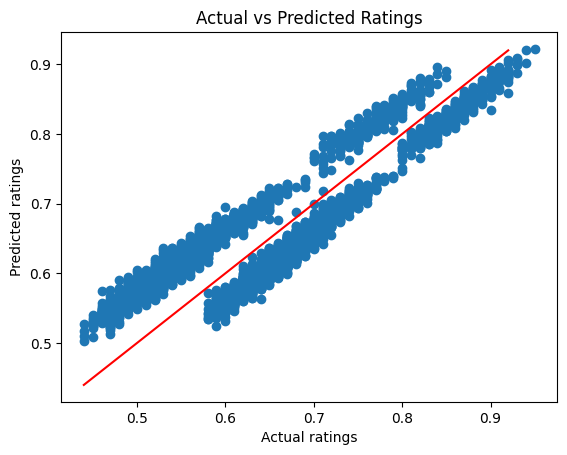

In [275]:
import matplotlib.pyplot as plt

plt.scatter(y, y_pred)
plt.xlabel('Actual ratings')
plt.ylabel('Predicted ratings')
plt.title('Actual vs Predicted Ratings')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

In [257]:
df = df[['approve_dttm', 'approve_flg', 'initial_approved_amt', 'initial_term', 'age']]

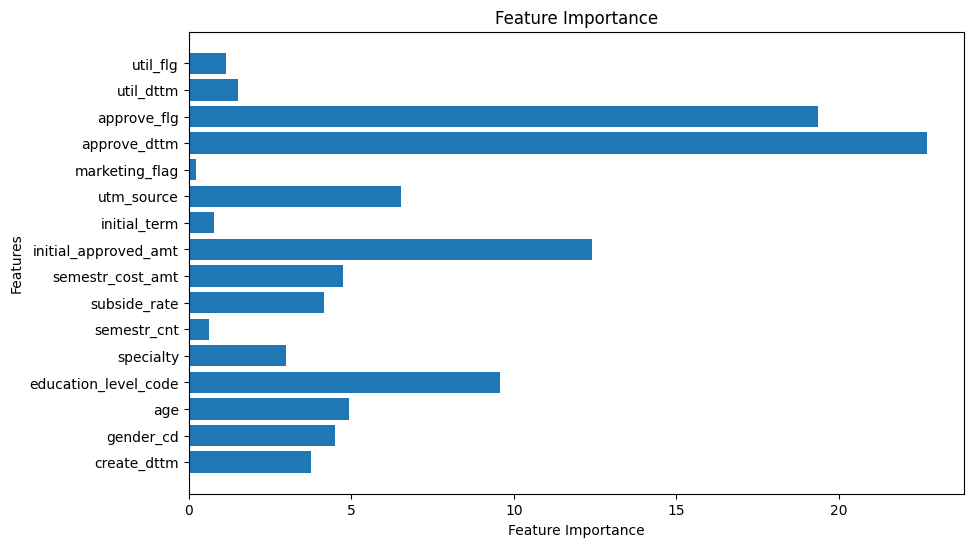

In [230]:
import matplotlib.pyplot as plt

# Получение важности признаков
feature_importances = model.get_feature_importance(train_pool)

# Визуализация важности признаков
features = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

<Axes: >

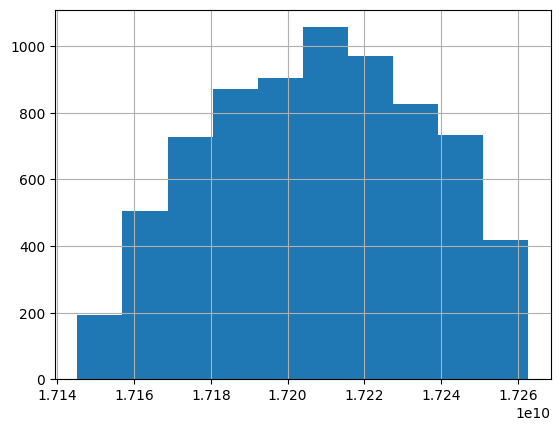

In [232]:
df[df['approve_dttm'] != 0]['approve_dttm'].hist()

In [238]:
df['flag_approve_dttm'] = (df['approve_dttm'] > 0).astype(int)
df.drop('approve_dttm', axis=1, inplace=True)

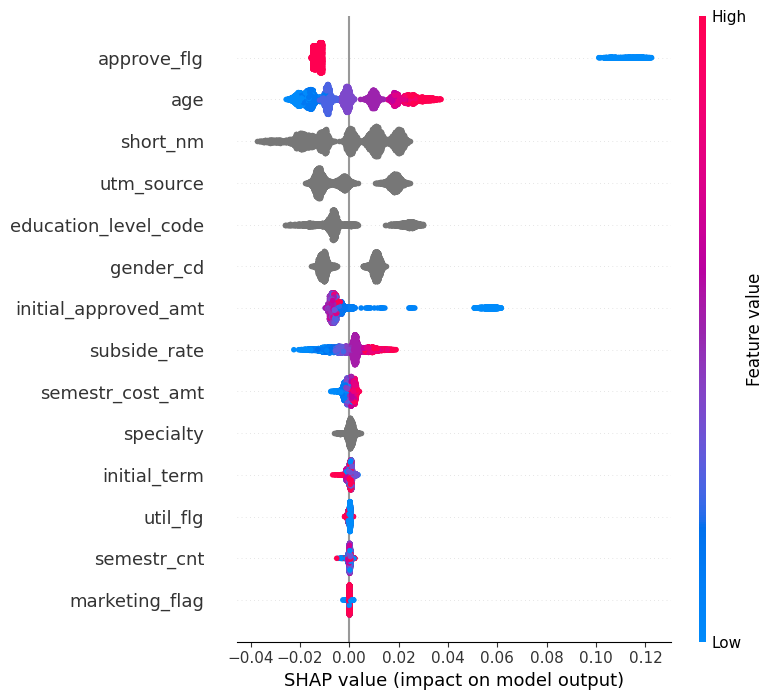

In [55]:
# Важность признаков с помощью SHAP
shap_values = model.get_feature_importance(train_pool, type="ShapValues")

# Визуализация SHAP значений для первых 100 примеров
import shap
shap.initjs()

# Преобразуем SHAP значения (последний столбец - это предсказание модели)
shap_values_without_last_column = shap_values[:, :-1]

# Построим объяснение для первых 100 наблюдений
shap.summary_plot(shap_values_without_last_column, X_train, feature_names=features)

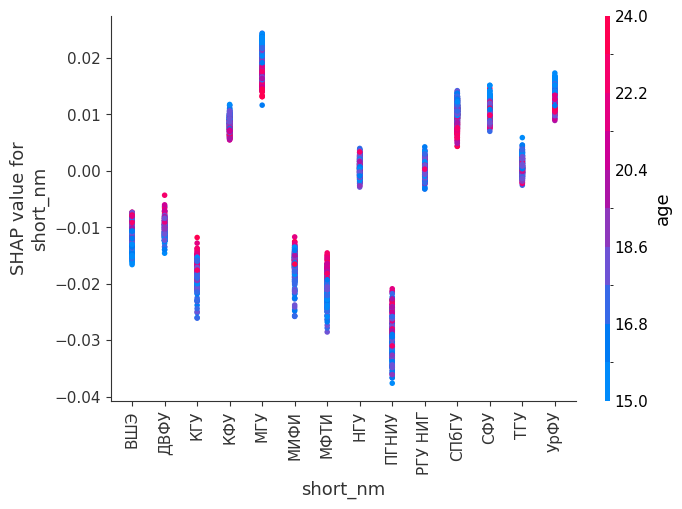

In [56]:
shap.dependence_plot("short_nm", shap_values_without_last_column, X_train)

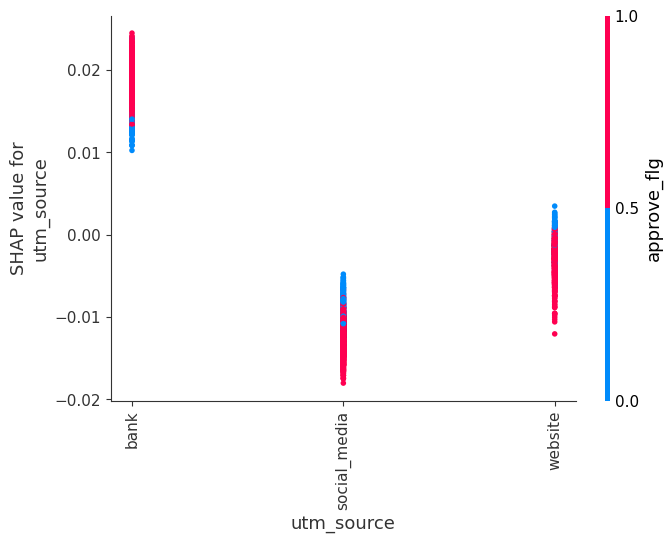

In [57]:
shap.dependence_plot("utm_source", shap_values_without_last_column, X_train)

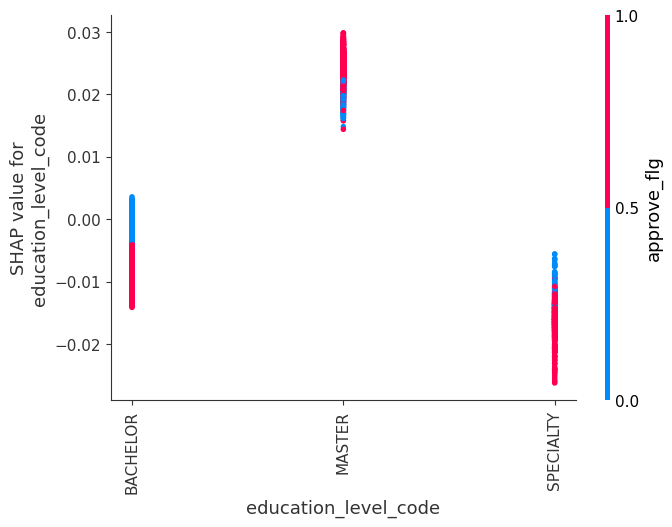

In [58]:
shap.dependence_plot("education_level_code", shap_values_without_last_column, X_train)

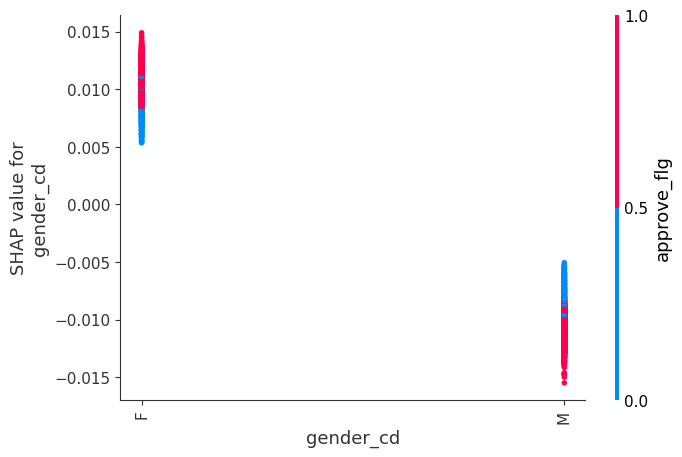

In [59]:
shap.dependence_plot("gender_cd", shap_values_without_last_column, X_train)